In [65]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, random
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

In [4]:
### CONNECT TO PRAW
r = conn.connect(controller="ModLog")

Version 3.5.0 of praw is outdated. Version 4.4.0 was released Tuesday February 21, 2017.


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


In [5]:
actions = []
for row in db_engine.execute(text("select * from mod_actions WHERE subreddit_id = '2rfxx' ORDER BY created_utc ASC;")):
    action = {}
    action_data = json.loads(row['action_data'])
    for key in action_data.keys():
        action[key] = action_data[key]
    for key in row.keys():
        action[key]=row[key]
    del action['action_data']
    actions.append(action)

In [6]:
days_covered = (max([x['created_utc'] for x in actions]) - min([x['created_utc'] for x in actions])).days
print("Within the period of {0} days".format(days_covered))
print("{0} banned per day".format(Counter([x['action'] for x in actions])['banuser'] / days_covered))

Within the period of 201 days
8.124378109452737 banned per day


In [76]:
min([x['created_utc'] for x in actions])

datetime.datetime(2016, 9, 3, 23, 58, 41)

In [77]:
max([x['created_utc'] for x in actions])

datetime.datetime(2017, 3, 24, 18, 49, 55)

In [8]:
print("{0} actions to ban a user.".format(Counter([x['action'] for x in actions])['banuser']))
print("{0} actions to unban a user.".format(Counter([x['action'] for x in actions])['unbanuser']))

1633 actions to ban a user.
343 actions to unban a user.


### Generate per-user dataset

In [9]:
def persondict():
    return {
        "target_author":None,
        "target_fullname": None,
        "ban_actions":[], #list of tuples
        "post_actions":defaultdict(list),
        "comment_actions":defaultdict(list)
    }

people = defaultdict(persondict)

In [10]:
for action in actions:
    action_type = action['action']
    author = action['target_author'].lower()
    people[author]['target_author'] = author
    target_id = action['target_fullname']
    if(action_type in ["removecomment", "approvecomment"]):
        people[author]['comment_actions'][target_id].append((action['created_utc'], action))
    elif(action_type in ["approvelink", "removelink"]):
        people[author]['post_actions'][target_id].append((action['created_utc'], action))
    elif(action_type in ["banuser", "unbanuser"]): 
        people[author]['target_author_fullname'] = action['target_fullname']
        people[author]['ban_actions'].append((action['created_utc'], action))

In [11]:
#Counter([x['action'] for x in actions])
all_banned = [p for p in people.values() if len(p['ban_actions'])>0]

In [12]:
def current_ban_status(person):
    ban_actions = sorted(person['ban_actions'], key=lambda x: x[0], reverse=True)
    current_ban_status = ban_actions[0][1]['action']=="banuser"
    time_since_ban = None
    time_since_unban = None
    time_before_unban = None
    if(current_ban_status):
        timediff = datetime.datetime.now() - ban_actions[0][0]
        time_since_ban = timediff.days + timediff.seconds / 86400
    else:
        ban_datetime = None
        for action in ban_actions:
            if(action[1]['action']=="banuser"):
                ban_datetime = action[0]
        if(ban_datetime!=None):
            timediff = ban_actions[0][0] - ban_datetime
            time_before_unban = timediff.days + timediff.seconds/ 86400
            timediff = datetime.datetime.now() - ban_datetime
            time_since_unban = timediff.days + timediff.seconds/ 86400
            
    return {"current_ban_status": current_ban_status,
            "days_since_ban":time_since_ban,
            "days_before_unban": time_before_unban,
            "days_since_unban": time_since_unban,
            "total_ban_actions": len(ban_actions),
            "ban_count": len([x for x in ban_actions if x[1]['action'] =="banuser"]),
            "unban_count": len([x for x in ban_actions if x[1]['action'] =="unbanuser"])}

def removal_stats(person):
    modded_comments = len(list(person['comment_actions'].values()))
    modded_posts = len(list(person['post_actions'].values()))
    return {"modded_comments": modded_comments,
            "modded_posts": modded_posts}

In [13]:
all_banned_people = []
for person in all_banned:
    stats = {"author":person['target_author'].lower(), "author_fullname":person['target_author_fullname']}
    stats.update(current_ban_status(person))
    stats.update(removal_stats(person))
    all_banned_people.append(stats)

### Collect User Information

In [21]:
account_info = {}
#old_account_info = copy.copy(account_info)
#account_info = {}
#for username, account in old_account_info.items():
#    account_info[username.lower()] = account

In [27]:
print("Banned Accounts: {0}".format(len(all_banned_people)))
print("Accounts Successfully Queried: {0}".format(len(account_info)))

Banned Accounts: 1619
Accounts Successfully Queried: 1619


In [26]:
for account in [x['author'] for x in all_banned_people]:
    if((account in account_info.keys())!=True):
        try:
            print("--> FETCHING {0}".format(account))
            a = r.get_redditor(account)
            a.refresh()
            account_info[account.lower()] = a.json_dict
            time.sleep(2)
        except:
            account_info[account.lower()] = None
            pass

--> FETCHING boohoooooo


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/boohoooooo/about/.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/boohoooooo/about/.json


--> FETCHING elarabizlb


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/elarabizlb/about/.json


--> FETCHING tahirivkc


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tahirivkc/about/.json


--> FETCHING athnael


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/athnael/about/.json


--> FETCHING boostinggames


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/boostinggames/about/.json


--> FETCHING thiswillneverend3


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/thiswillneverend3/about/.json


--> FETCHING mememeupbruh


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mememeupbruh/about/.json


--> FETCHING bettachiosg


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bettachiosg/about/.json


--> FETCHING ihumanl


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ihumanl/about/.json


--> FETCHING daseulgimotti


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/daseulgimotti/about/.json


--> FETCHING runicecho


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/runicecho/about/.json


--> FETCHING azgourikgz


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/azgourikgz/about/.json


--> FETCHING kadiriqjt


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kadiriqjt/about/.json


--> FETCHING g2perkz


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/g2perkz/about/.json


--> FETCHING bernatiyhd


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bernatiyhd/about/.json


--> FETCHING rissaniqjm


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rissaniqjm/about/.json


--> FETCHING azgouripca


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/azgouripca/about/.json


--> FETCHING olivernoah0070


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/olivernoah0070/about/.json


--> FETCHING baickie


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/baickie/about/.json


--> FETCHING azgourizyv


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/azgourizyv/about/.json


--> FETCHING tiaziyzt


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tiaziyzt/about/.json


--> FETCHING canthearyoubot4


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/canthearyoubot4/about/.json


--> FETCHING krpeyton


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/krpeyton/about/.json


--> FETCHING lmelhawixfo


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawixfo/about/.json


--> FETCHING scga05


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/scga05/about/.json


--> FETCHING suplexduplex


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/suplexduplex/about/.json


--> FETCHING karimiafy


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/karimiafy/about/.json


--> FETCHING boogyboi88


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/boogyboi88/about/.json


--> FETCHING niggasanch


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/niggasanch/about/.json


--> FETCHING tijanivdf


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tijanivdf/about/.json


--> FETCHING magicmikexxxxl


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/magicmikexxxxl/about/.json


--> FETCHING sablinksex


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sablinksex/about/.json


--> FETCHING dj_kled


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/dj_kled/about/.json


--> FETCHING kadiriaia


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kadiriaia/about/.json


--> FETCHING daseulgi


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/daseulgi/about/.json


--> FETCHING serfaticyc


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfaticyc/about/.json


--> FETCHING woessoe


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/woessoe/about/.json


--> FETCHING karimizmy


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/karimizmy/about/.json


--> FETCHING karma_beggar_bot


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/karma_beggar_bot/about/.json


--> FETCHING unlicky123


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/unlicky123/about/.json


--> FETCHING lmelhawilif


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawilif/about/.json


--> FETCHING billyboosted


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/billyboosted/about/.json


--> FETCHING leefuckingsin


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/leefuckingsin/about/.json


--> FETCHING iam_brood


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/iam_brood/about/.json


--> FETCHING lisapistol


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lisapistol/about/.json


--> FETCHING tijanimdr


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tijanimdr/about/.json


--> FETCHING ytxrvg


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ytxrvg/about/.json


--> FETCHING elarabipas


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/elarabipas/about/.json


--> FETCHING williemporse


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/williemporse/about/.json


--> FETCHING kadirimrm


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kadirimrm/about/.json


--> FETCHING fechtaliazq


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/fechtaliazq/about/.json


--> FETCHING fechtalinfd


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/fechtalinfd/about/.json


--> FETCHING reinbod


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/reinbod/about/.json


--> FETCHING diepiofun


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/diepiofun/about/.json


--> FETCHING amgonnakillu


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/amgonnakillu/about/.json


--> FETCHING quack_bot


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/quack_bot/about/.json


--> FETCHING sovietunion1337


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sovietunion1337/about/.json


--> FETCHING negrachixua


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/negrachixua/about/.json


--> FETCHING soldierofnod55


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/soldierofnod55/about/.json


--> FETCHING lmelhawikgi


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawikgi/about/.json


--> FETCHING goliathgawd


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/goliathgawd/about/.json


--> FETCHING bernatilis


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bernatilis/about/.json


--> FETCHING serfatiicj


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfatiicj/about/.json


--> FETCHING pm_me_klaj_misplays


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/pm_me_klaj_misplays/about/.json


--> FETCHING kylerocker


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kylerocker/about/.json


--> FETCHING haboubyli


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/haboubyli/about/.json


--> FETCHING aquaified


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/aquaified/about/.json


--> FETCHING leagueoflegends_pl


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/leagueoflegends_pl/about/.json


--> FETCHING haboubrbh


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/haboubrbh/about/.json


--> FETCHING letschtenz


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/letschtenz/about/.json


--> FETCHING jahangeerseo


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/jahangeerseo/about/.json


--> FETCHING tijanihui


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tijanihui/about/.json


--> FETCHING h2wha7


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/h2wha7/about/.json


--> FETCHING serfatiyrd


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfatiyrd/about/.json


--> FETCHING pepe_the_cuck


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/pepe_the_cuck/about/.json


--> FETCHING kadirinsp


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kadirinsp/about/.json


--> FETCHING serfatiaat


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfatiaat/about/.json


--> FETCHING rissanivvp


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rissanivvp/about/.json


--> FETCHING awesomeismatt


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/awesomeismatt/about/.json


--> FETCHING dima321


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/dima321/about/.json


--> FETCHING aloyka


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/aloyka/about/.json


--> FETCHING nyetworks


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/nyetworks/about/.json


--> FETCHING cotovanudima0202


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/cotovanudima0202/about/.json


--> FETCHING saku65


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/saku65/about/.json


--> FETCHING stickleyman7


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/stickleyman7/about/.json


--> FETCHING tijanievt


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tijanievt/about/.json


--> FETCHING bennaniwkq


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bennaniwkq/about/.json


--> FETCHING lmelhawijip


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawijip/about/.json


--> FETCHING [deleted]


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/[deleted]/about/.json


--> FETCHING ovetesticals


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ovetesticals/about/.json


--> FETCHING of_have_bot


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/of_have_bot/about/.json


--> FETCHING watchshowsmovies


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/watchshowsmovies/about/.json


--> FETCHING hiyalongla


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/hiyalongla/about/.json


--> FETCHING azgourilms


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/azgourilms/about/.json


--> FETCHING bettachiatx


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bettachiatx/about/.json


--> FETCHING lmelhawirss


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawirss/about/.json


--> FETCHING taipeichlngchong


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/taipeichlngchong/about/.json


--> FETCHING posts_bad_content


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/posts_bad_content/about/.json


--> FETCHING araqka


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/araqka/about/.json


--> FETCHING lmelhawisvb


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawisvb/about/.json


--> FETCHING lmelhawiwwu


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawiwwu/about/.json


--> FETCHING tiaziley


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tiaziley/about/.json


--> FETCHING bernatiznn


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bernatiznn/about/.json


--> FETCHING clearlul


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/clearlul/about/.json


--> FETCHING lmelhawikon


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawikon/about/.json


--> FETCHING rissaniqez


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rissaniqez/about/.json


--> FETCHING honestlybot


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/honestlybot/about/.json


--> FETCHING serfatiqas


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfatiqas/about/.json


--> FETCHING karimizdo


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/karimizdo/about/.json


--> FETCHING sktthapa


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sktthapa/about/.json


--> FETCHING rissanifrr


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rissanifrr/about/.json


--> FETCHING maymaysdank


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/maymaysdank/about/.json


--> FETCHING lmelhawimby


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawimby/about/.json


--> FETCHING kappachino12


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kappachino12/about/.json


--> FETCHING shado95


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/shado95/about/.json


--> FETCHING kadirinqj


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kadirinqj/about/.json


--> FETCHING baickiev2


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/baickiev2/about/.json


--> FETCHING freakytrolls


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/freakytrolls/about/.json


--> FETCHING mortimz


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mortimz/about/.json


--> FETCHING serfatilbz


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/serfatilbz/about/.json


--> FETCHING fechtaliinq


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/fechtaliinq/about/.json


--> FETCHING azgourihad


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/azgourihad/about/.json


--> FETCHING bennaniojj


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bennaniojj/about/.json


--> FETCHING lmelhawifaf


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawifaf/about/.json


--> FETCHING hjokak


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/hjokak/about/.json


--> FETCHING alper555216


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/alper555216/about/.json


--> FETCHING runawaykunta


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/runawaykunta/about/.json


--> FETCHING eyepatchouli


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/eyepatchouli/about/.json


--> FETCHING bennanikis


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bennanikis/about/.json


--> FETCHING danteadd


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/danteadd/about/.json


--> FETCHING bsfired


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bsfired/about/.json


--> FETCHING blek_reeves


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/blek_reeves/about/.json


--> FETCHING lmelhawicwa


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lmelhawicwa/about/.json


--> FETCHING tiazibcf


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/tiazibcf/about/.json


### Add User Information To all_banned_people

In [31]:
list(account_info.values())[0]

{'comment_karma': 27999,
 'created': 1392893901.0,
 'created_utc': 1392865101.0,
 'has_verified_email': None,
 'hide_from_robots': False,
 'id': 'fcypz',
 'is_friend': False,
 'is_gold': False,
 'is_mod': False,
 'link_karma': 11570,
 'name': 'Imzarth',
 'subreddit': None,
 'verified': False}

In [33]:
for person in all_banned_people:
    key = person['author']
    if account!=None and key in account_info.keys():
        account = account_info[key]
        person['author.info'] = True
        for k in account.keys():
            person['author.' + k] = account[k]
    else:
        person['author.info'] = False

print(list(account_info.values())[0])
print(all_banned_people[0])
print(list(account_info.keys())[0])

{'has_verified_email': None, 'created_utc': 1392865101.0, 'comment_karma': 27999, 'is_mod': False, 'link_karma': 11570, 'subreddit': None, 'name': 'Imzarth', 'is_gold': False, 'verified': False, 'is_friend': False, 'created': 1392893901.0, 'id': 'fcypz', 'hide_from_robots': False}
{'author.hide_from_robots': False, 'ban_count': 1, 'days_since_ban': 195.1670949074074, 'author.is_mod': False, 'author_fullname': 't2_11acp3', 'total_ban_actions': 1, 'current_ban_status': True, 'days_before_unban': None, 'author.created_utc': 1473417395.0, 'author.subreddit': None, 'author.has_verified_email': False, 'author.name': 'xToon2', 'modded_comments': 4, 'author': 'xtoon2', 'author.id': '11acp3', 'author.is_friend': False, 'author.info': False, 'author.is_gold': False, 'author.created': 1473446195.0, 'unban_count': 0, 'author.verified': False, 'author.link_karma': 1, 'days_since_unban': None, 'modded_posts': 1, 'author.comment_karma': 16}
imzarth


### Analyze Information

In [34]:
ban_df = pd.DataFrame(all_banned_people)
ban_df.head()

,author,author.comment_karma,author.created,author.created_utc,author.has_verified_email,author.hide_from_robots,author.id,author.info,author.is_friend,author.is_gold,...,author_fullname,ban_count,current_ban_status,days_before_unban,days_since_ban,days_since_unban,modded_comments,modded_posts,total_ban_actions,unban_count
0,xtoon2,16.0,1.473446e+09,1.473417e+09,False,False,11acp3,False,False,False,...,t2_11acp3,1,True,NaN,195.167095,NaN,4,1,1,0
1,i_met_a_post,4003.0,1.424751e+09,1.424722e+09,False,False,ljosv,False,False,False,...,t2_ljosv,0,False,NaN,NaN,NaN,1,1,1,1
2,ghoulerino,-51.0,1.445813e+09,1.445784e+09,False,False,rg9d0,False,False,False,...,t2_rg9d0,1,True,NaN,99.595150,NaN,4,7,1,0
3,sleepingtalent901,309.0,1.417862e+09,1.417833e+09,True,False,ju0vc,False,False,False,...,t2_ju0vc,1,True,NaN,106.957245,NaN,2,3,1,0
4,stay_triggered,-28.0,1.471568e+09,1.471540e+09,False,False,10o0oj,False,False,False,...,t2_10o0oj,1,True,NaN,200.096285,NaN,2,0,1,0


In [35]:
print(ban_df.current_ban_status.describe())
(1076 - 899)/1076
1076-889

count     1619
unique       2
top       True
freq      1341
Name: current_ban_status, dtype: object


187

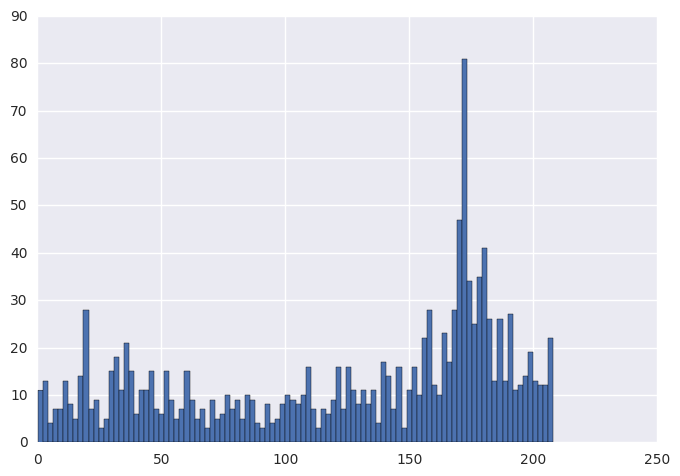

In [36]:
ban_df.days_since_ban.hist(bins=102)
#ban_df.days_since_ban.describe()
#np.mean(list(Counter(ban_df[ban_df.days_since_ban<60].days_since_ban.round()).values()))

count    232.000000
mean     122.253612
std       57.854195
min        6.522674
25%       69.097086
50%      133.355712
75%      170.580972
max      207.011551
Name: days_since_unban, dtype: float64

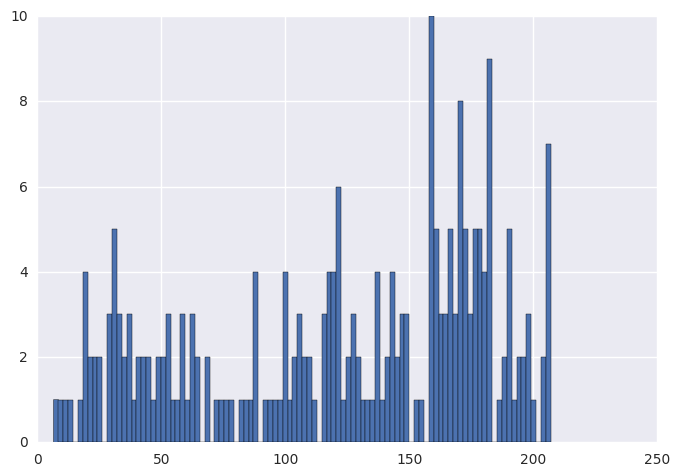

In [37]:
ban_df.days_since_unban.hist(bins=102)
ban_df.days_since_unban.describe()

8.10851273148148

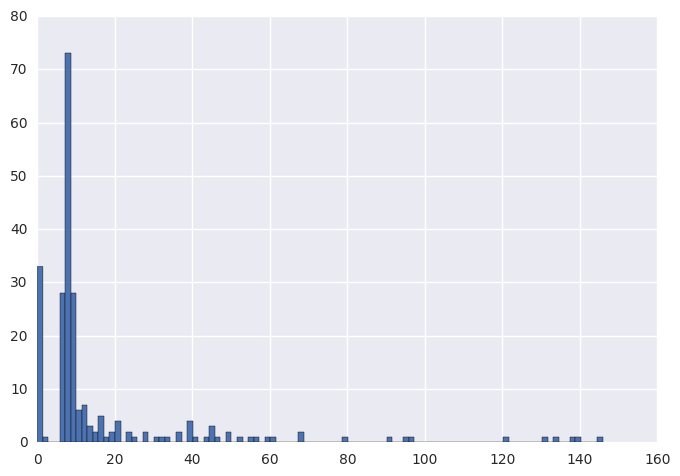

In [38]:
ban_df.days_before_unban.hist(bins=102)
ban_df.days_before_unban.median()

In [39]:
ban_df.current_ban_status.describe()

count     1619
unique       2
top       True
freq      1341
Name: current_ban_status, dtype: object

In [40]:
#ban_df.boxplot(column="author.created", by="current_ban_status")

### Initial Report to r/leagueoflegends

Hi all,

Before our conversation later today, here are some things I learned by analyzing the mod log.

**Basic Summary Statistics About Bans & Unbans**

Within the last 102 days on r/leagueoflegends, 1089 actions were taken to ban a user, and 208 actions were taken to unban a user. Among bans, that amounts to 10.7 users banned per day. It looks like you had a pretty large spike in bans in early October, with roughly 50 in one day (among those who are still banned), with the bans per day staying mostly within 5 to 10 in more recent months.

I also looked at the accounts that received bans and unbans in the period. I'm still fetching data from the reddit API about basic statistics for these accounts.

**Information About Unbanned Accounts**

16% of banned accounts have been unbanned through your process, a total of 187 across the last 102 days. Among accounts that are unbanned, the median time before becoming unbanned is 8 days, although more than 10 accounts were unbanned more than a month after being initially banned.

# Integrate with Snoonotes

In [41]:
import requests
baseurl = "https://snoonotes.com"
headers = {'User-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:51.0) Gecko/20100101 Firefox/51.0"}
cookies = {"ARRAffinity":"ef04bb6afe45d7abaef12256b52f384ceec2bbaf657c7041c3947d764faaffe9",
           "snPrefs":"%7B%22wiki%22%3Afalse%2C%22read%22%3Afalse%7D",
           "bog":"E03Bya0sXViPbWd1Qzmvf0Eau9pLpfCaNsV-vbYD_Npgc27JxtHDIdmCB6U2VhxcUnKNk12A_ETNiFOr2cnJcw01kpfhC9i7CHXIIJ2mdK-dBvj6q7XHfGJM93dT5ZrLyVcs6j8JZTdWNAAWsobyUcota0KtjqdPeDP23OWUYqgwbvy94V98BSRVY0CRQFmc7ULvFisOKbdGnG4AdXSHaEtSie85nHKX_H8w-a0MfRpgB4F4G_o3e3oneL7Y4foadP8jiP5yOPXynvQKm4k9ikfNMBhsr2v8F41ZnhT_st9t0vkjm_zEbaHkV1wPNrF6W-fIcuFM52iG2EZFKgPvb4kmtOe-P38lmYPx1YsSkHEIxKmJd0ZcYDyLLnwrqpN_vXyk1i67gESF3YD5GusbylJ_ItdeQ8xSZOc6R6IP31pu8ucKX_aVEpelScKtPSbFWPvYCQCZtVYQfeODj0o8ZJT8GC31qp9BclzmXlIjLrwqBokESGK11s9exbDdZamZO1_wynlnIsCObcQbzjoaNZsSe0re5VSkq-Wm6DG7Ofmp3JjP2lUqDbsZj6lmayyt7HBssDNVLV28QzPDCIghuNZkWhqyD2G0cPD5-kdjUpUFjxgzZ376Col1-a2GuDWR"}


### Load the List of Usernames with Notes

In [42]:
#url = 'https://snoonotes.com/api/Account/GetCurrentUser'
url = 'https://snoonotes.com/api/Note/GetUsernamesWithNotes'
rq = requests.get(url,
                headers=headers,
                cookies=cookies)
usernames_with_notes = json.loads(rq.text)

### Fetch Notes for Usernames

In [43]:
#usernames_with_notes[0:100]
#paged set of all user notes: 11592
#non-paged set of all user notes
#len(usernames_with_notes)
#len(all_user_notes)

In [44]:
all_user_notes = {}

url = baseurl + "/api/Note/GetNotes"
headers = {'User-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:51.0) Gecko/20100101 Firefox/51.0",
           'content-type':'application/json'}
offset = 0
# payload = usernames_with_notes
# n = requests.post(url, cookies=cookies, headers=headers, json=payload)
# if(n.status_code == 200):
#     user_notes = json.loads(n.text)
#     all_user_notes.update(user_notes)

while(offset < len(usernames_with_notes)):
    payload = usernames_with_notes[0+offset:1000 + offset]
    n = requests.post(url, cookies=cookies, headers=headers, json=payload)
    if(n.status_code == 200):
        user_notes = json.loads(n.text)
        all_user_notes.update(user_notes)
        offset +=1000 
        print("{0}...".format(offset))
    else:
        print("Difficulty with request. Code {0}".format(n.status_code))

1000...
2000...
3000...
4000...
5000...
6000...
7000...
8000...
9000...
10000...
11000...
12000...


In [45]:
#len(all_user_notes)

In [46]:
list(all_user_notes.values())[0]

[{'Message': 'homophobic insults',
  'NoteID': 67826,
  'NoteTypeID': 509,
  'ParentSubreddit': None,
  'SubName': 'leagueoflegends',
  'Submitter': 'daswef',
  'Timestamp': '2016-07-18T21:54:44Z',
  'Url': 'https://reddit.com/r/leagueoflegends/comments/4tefi7/-/d5hchwt/'}]

### Fetch usernotes schema

In [47]:
url = baseurl + "/restapi/Subreddit"
s = requests.get(url, cookies=cookies, headers=headers)
if(s.status_code == 200):
    schemas = json.loads(s.text)
else:
    print("Error querying data")

In [48]:
#schemas[1]

### Create a Subset of Subreddit's Notes, with Schema Included

In [49]:
sub_name="leagueoflegends"
sub_schema = None
for schema in schemas:
    if(schema['SubName']==sub_name):
        sub_schema = schema

sub_schema_codes = {}
for note_type in sub_schema['Settings']['NoteTypes']:
    sub_schema_codes[note_type['NoteTypeID']] = note_type

sub_user_notes = defaultdict(list)
for username, notes in all_user_notes.items():
    this_user_notes = []
    user_sub_notes = [x for x in notes if x['SubName'] == sub_name]
    for note in user_sub_notes:
        note['NoteTypeName'] = sub_schema_codes[note['NoteTypeID']]['DisplayName']
    sub_user_notes[username] = user_sub_notes

In [50]:
#list(all_user_notes.keys())[0:30]

In [51]:
all_notes_for_all = []
for notes in sub_user_notes.values():
    all_notes_for_all += notes
print("Earliest Note: {0}".format(min([parser.parse(x['Timestamp']) for x in all_notes_for_all])))
print("Note Type Breakdown:")
Counter([x['NoteTypeName'] for x in all_notes_for_all])

Earliest Note: 2015-05-12 12:23:23+00:00
Note Type Breakdown:


Counter({'Abuse Warning': 4817,
         'Account Watch': 24,
         'Ban': 2776,
         'Bot Ban': 54,
         'Del/res warn': 360,
         'Good Contributor': 69,
         'None': 649,
         'Perma Ban': 1452,
         'Spam Warning': 2329,
         'Spam Watch': 3316})

In [52]:
len(sub_user_notes.values())

11830

In [53]:
list(sub_user_notes.values())[4]

[{'Message': 'ins',
  'NoteID': 68658,
  'NoteTypeID': 510,
  'NoteTypeName': 'Ban',
  'ParentSubreddit': None,
  'SubName': 'leagueoflegends',
  'Submitter': 'SimplifyEUW',
  'Timestamp': '2016-10-23T05:34:40Z',
  'Url': 'https://reddit.com/r/leagueoflegends/comments/58w6y4/-/d93y0ml/'},
 {'Message': 'Racist',
  'NoteID': 68659,
  'NoteTypeID': 509,
  'NoteTypeName': 'Abuse Warning',
  'ParentSubreddit': None,
  'SubName': 'leagueoflegends',
  'Submitter': 'ReganDryke',
  'Timestamp': '2016-08-23T23:25:38Z',
  'Url': 'https://reddit.com/r/leagueoflegends/comments/4z7vbm/-/d6twj8g/'}]

# Make a List of a Single User's Arc of Moderation Experiences
* approvecomment
* approvelink
* banuser
* muteuser (info here: https://www.reddit.com/r/modnews/comments/3l791w/moderators_modmail_muting/ )
* removecomment
* removelink
* unbanuser

In [54]:
## this will be a per-person list of 
def experience():
    return {"timestamp":None,
            "source":None, # snoonotes or mod_actions 
            "type": None, # note['NoteTypeName'] or action['action']
            "submitter": None,
            "data": None}

def user_mod_history():
    return {
        "experiences":[], #list of experience dicts
        "metadata":{"snoonotes":0,
                    "mod_actions":0,
                    "notable_actions":0,
                    "earliest_experience":None}
    }

user_moderation_experiences = defaultdict(user_mod_history)

## STEP ONE: LOAD THE MOD ACTIONS
## (include all users that appear in mod actions)
actions_of_note = ['banuser', 'unbanuser','Abuse Warning','Ban', 'Perma Ban','Bot Ban','Spam Warning']

for action in actions:
    if action['action'] in ['approvecomment', 'approvelink', 
                            'banuser', 'muteuser', 'removecomment', 
                            'removelink', 'unbanuser']:
        
        target_author = action['target_author'].lower()
        
        action_info = experience()
        action_info['timestamp'] = utc.localize(action['created_utc'])
        action_info['type'] = action['action']
        action_info['source'] = "mod_actions"
        action_info['submitter'] = action['mod']
        action_info['data'] = action
        user_moderation_experiences[target_author]['experiences'].append(
            action_info
        )
        if(action_info['type'] in actions_of_note):
           user_moderation_experiences[target_author]['metadata']['notable_actions'] += 1 
        user_moderation_experiences[target_author]['metadata']['mod_actions'] += 1
        earliest_experience = user_moderation_experiences[
            target_author]['metadata']['earliest_experience'] 
        if(earliest_experience is None or earliest_experience > action_info['timestamp']):
            user_moderation_experiences[
                target_author]['metadata']['earliest_experience'] = action_info['timestamp']
        
        
## STEP TWO: LOAD THE NOTES ACTIONS
## (include all users that appear in notes)
for username, notes in sub_user_notes.items():
    username = username.lower()
    for note in notes:
        action_info = experience()
        action_info['timestamp'] = parser.parse(note['Timestamp'])
        action_info['type'] = note['NoteTypeName']
        action_info['source'] = "SnooNotes"
        action_info['submitter'] = note['Submitter']
        action_info['data'] = note
        user_moderation_experiences[username]['experiences'].append(
            action_info
        )
        if(action_info['type'] in actions_of_note):
           user_moderation_experiences[username]['metadata']['notable_actions'] += 1 
        user_moderation_experiences[username]['metadata']['snoonotes'] += 1

        earliest_experience = user_moderation_experiences[
            username]['metadata']['earliest_experience'] 
        if(earliest_experience is None or earliest_experience > action_info['timestamp']):
            user_moderation_experiences[
                username]['metadata']['earliest_experience'] = action_info['timestamp']        


### Create a Timeline for A User's Moderation Arc

In [55]:
all_types = ['banuser','unbanuser','removecomment','approvecomment', 
             'removelink','approvelink']
for user in user_moderation_experiences.values():
    for experience in user['experiences']:
        if experience['type'] not in all_types:
            all_types.append(experience['type'])

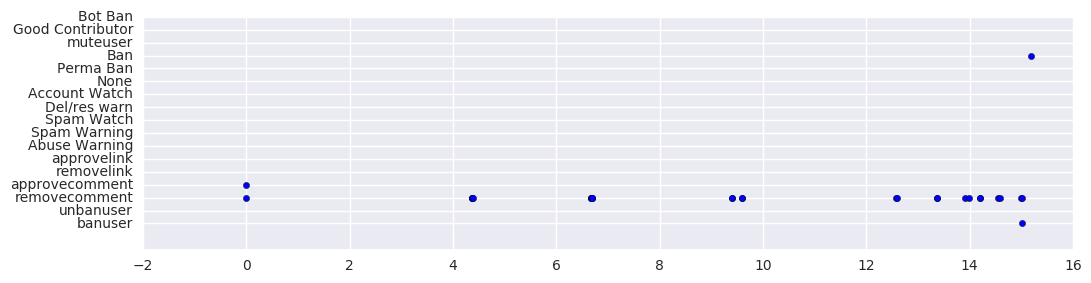

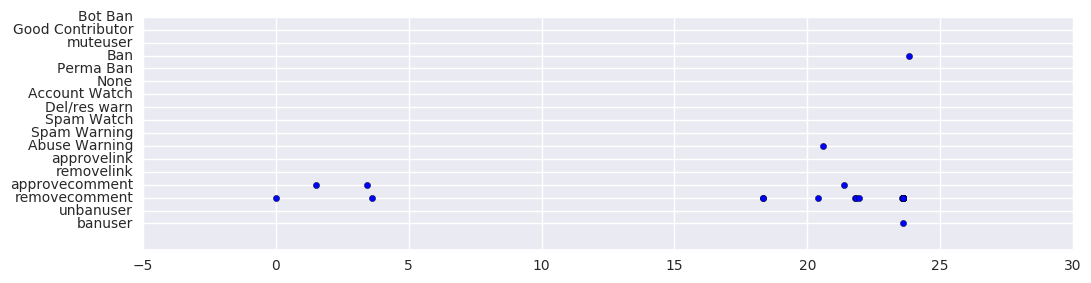

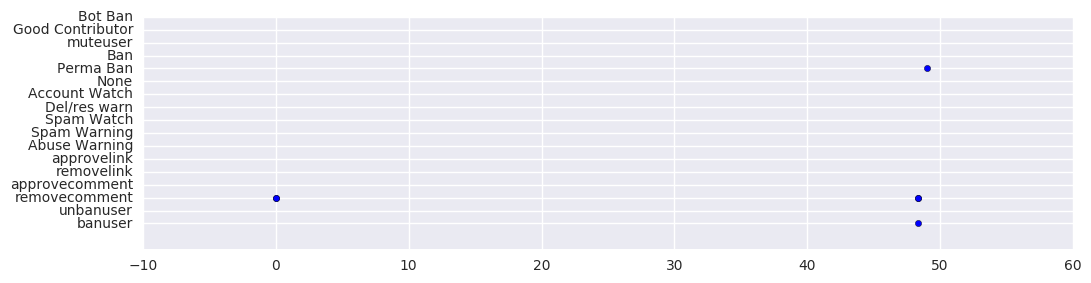

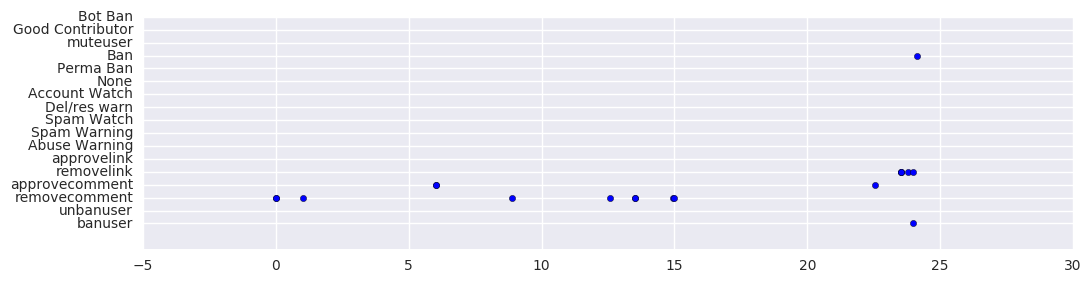

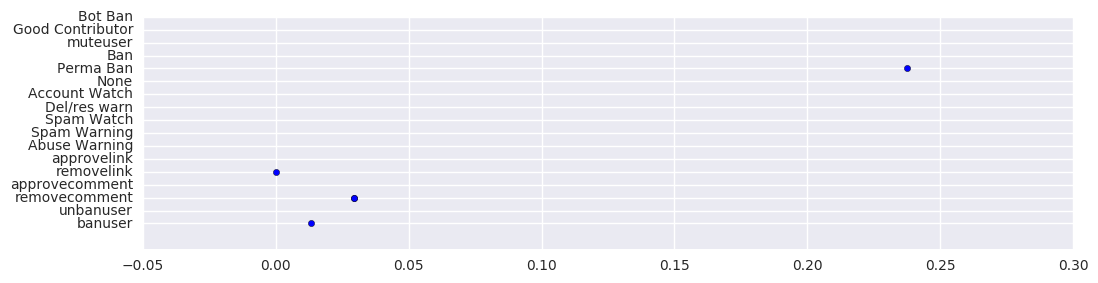

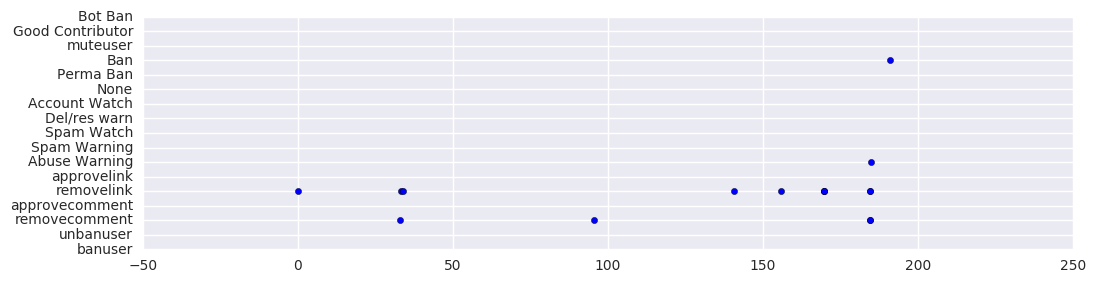

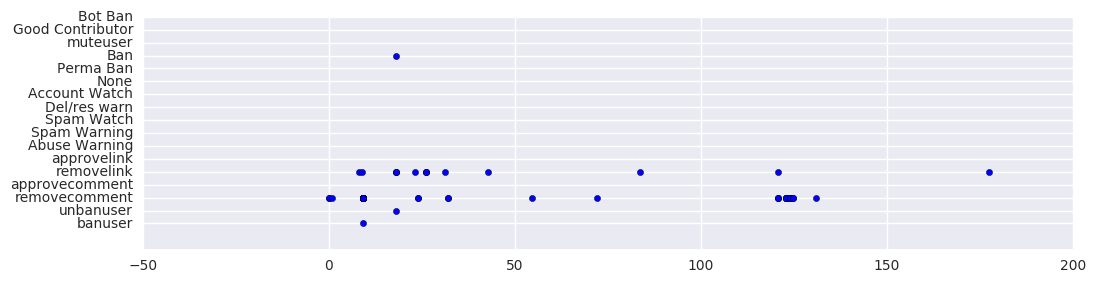

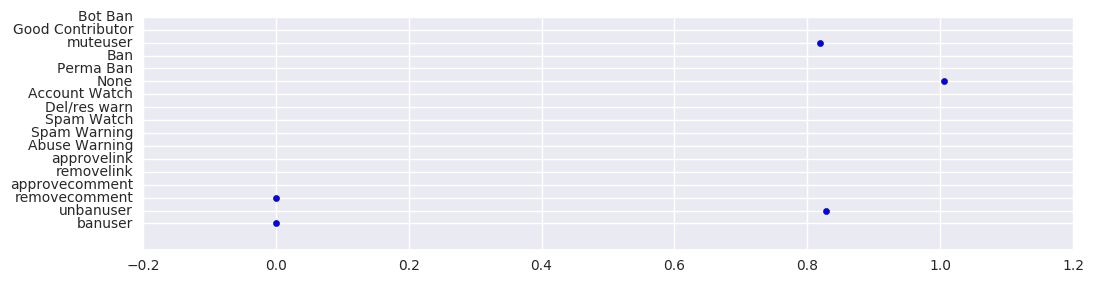

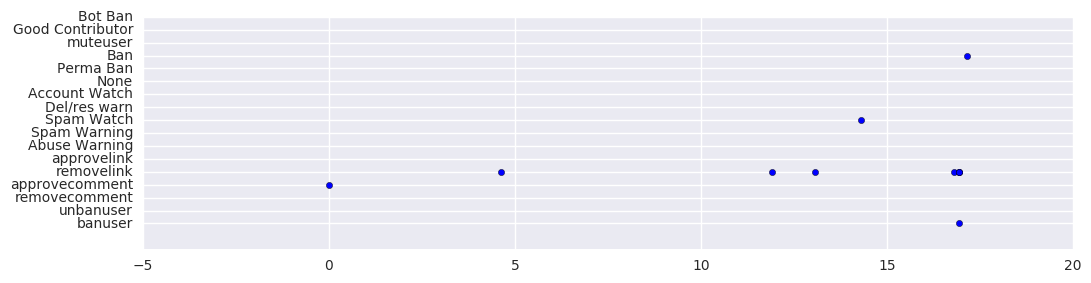

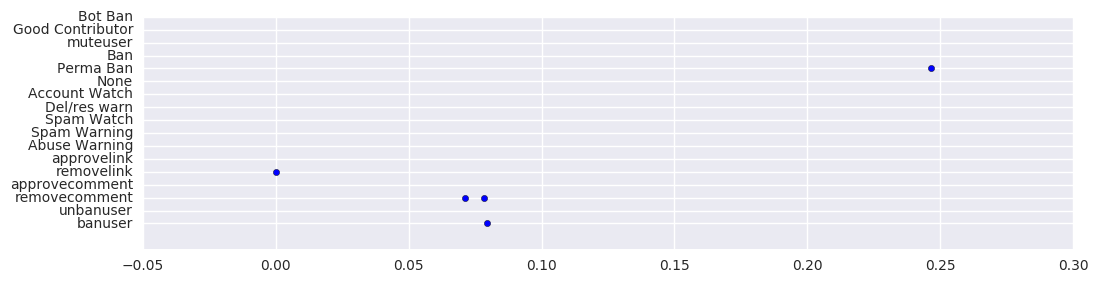

In [56]:
earliest_modaction = min([utc.localize(x['created_utc']) for x in actions])
for modlist in random.sample([x for x in user_moderation_experiences.values() 
                if(x['metadata']['notable_actions']>1 and 
                  x['metadata']['earliest_experience'] > earliest_modaction)], 10): 
    experiences = modlist['experiences']
    min_date = min([x['timestamp'] for x in experiences])

    days = []
    indices = []
    for experience in experiences:
        diff = experience['timestamp'] - min_date
        days_since = diff.days + diff.seconds / (60*60*24)
        days.append(days_since)
        type_index = all_types.index(experience['type'])
        indices.append(type_index)
    plt.figure(figsize=(12,3))
    plt.scatter(days, indices)
    plt.yticks(list(range(0,len(all_types))), all_types)
    plt.show()

## Time To Create Dataframes for Testing Hypotheses
* Per-person hypotheses
    * after a person is reinstated, what is the chance they will contribute again in the next week?
* Per-comment hypotheses
    * among people who are reinstated, what is the rate t which their comments are allowed?

In [66]:
final_date = max([x['created_utc'] for x in actions])
cutoff_period_days = 28
period_before_final_date = final_date - datetime.timedelta(days=cutoff_period_days)
print("Final Date: {0}".format(final_date))
print("N Weeks Before Final Date: {0}".format(period_before_final_date))

Final Date: 2017-03-30 18:48:31
N Weeks Before Final Date: 2017-03-02 18:48:31


### Create a Subset of Users That Have Been Unbanned
Limiting the dataset to users who were unbanned before the cutoff period

In [67]:
## TODO: NEED TO UPDATE THIS DATASET TO MAKE SURE
## IT INCLUDES ALL BANNED USERS, NOT JUST UNBANNED ONES
## AND THAT IT ALSO HAS INFORMATION ON WHETHER A NOTE WAS STORED

unbanned_users = {}
all_experience_types = []
for username, user_object in user_moderation_experiences.items():
    for experience in user_object['experiences']:
        all_experience_types.append(experience['type'])
        if(experience['type'] == "unbanuser" and experience['timestamp'] <=utc.localize(period_before_final_date)):
            sys.stdout.write(".")
            sys.stdout.flush()
            user_object['metadata']['unban_timestamp'] = experience['timestamp']
            unbanned_users[username] = user_object
            break
print("Identified {0} users who were unbanned before the cutoff".format(len(unbanned_users)))

.................................................................................................................................................................................................................................................................................................................Identified 305 users who were unbanned before the cutoff


In [68]:
#period_before_final_date

### Create  A Subset of Users That Have been Banned

In [69]:
banned_users = {}
all_experience_types = []
for username, user_object in user_moderation_experiences.items():
    for experience in user_object['experiences']:
        all_experience_types.append(experience['type'])
        if(experience['type'] == "banuser" and experience['timestamp'] <=utc.localize(period_before_final_date)):
            sys.stdout.write(".")
            sys.stdout.flush()
            user_object['metadata']['unban_timestamp'] = experience['timestamp']
            banned_users[username] = user_object
            break
print("Identified {0} users who were banned before the cutoff".format(len(banned_users)))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Now View Trajectories for Unbanned Users

In [70]:
#list(user_moderation_experiences.values())[0]

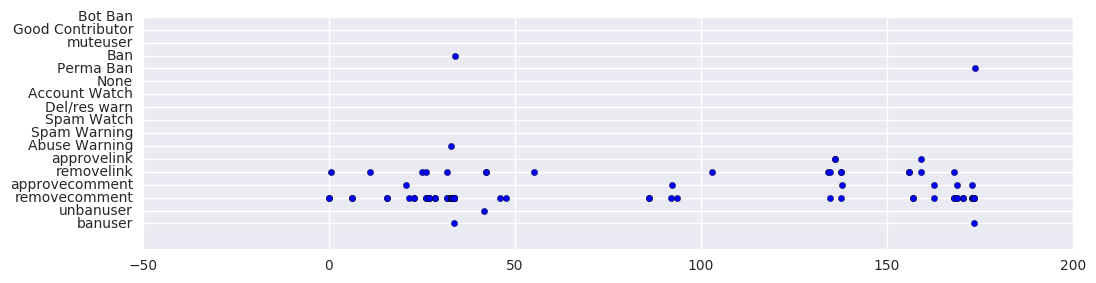

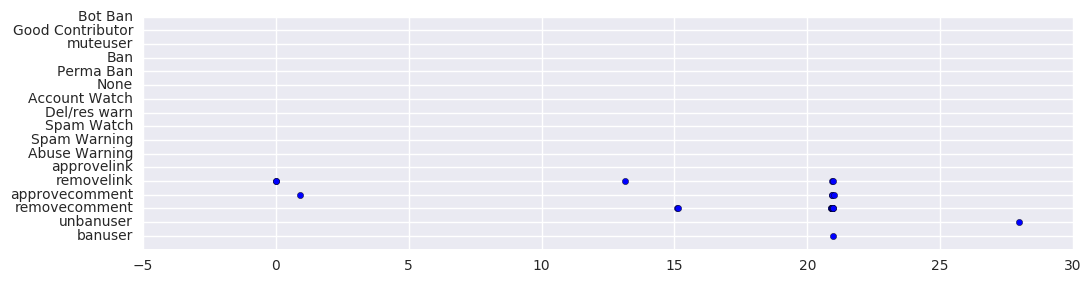

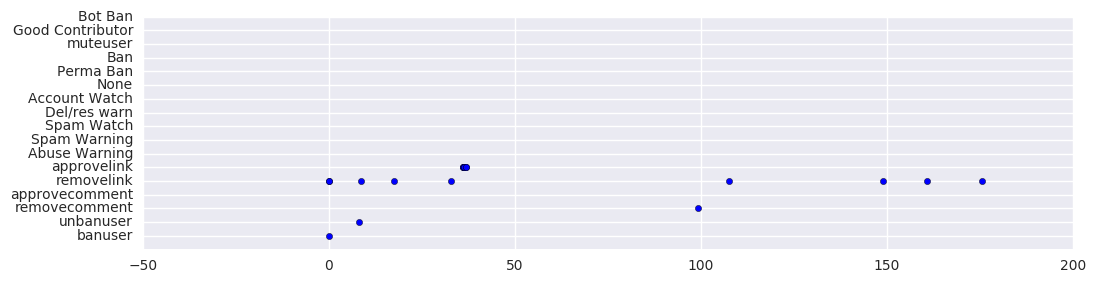

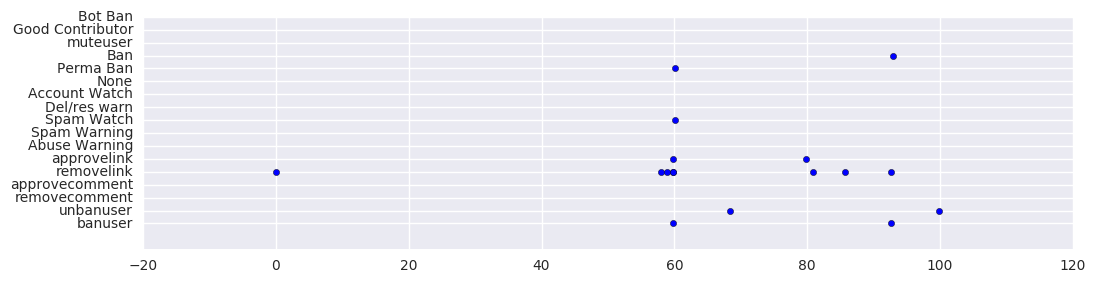

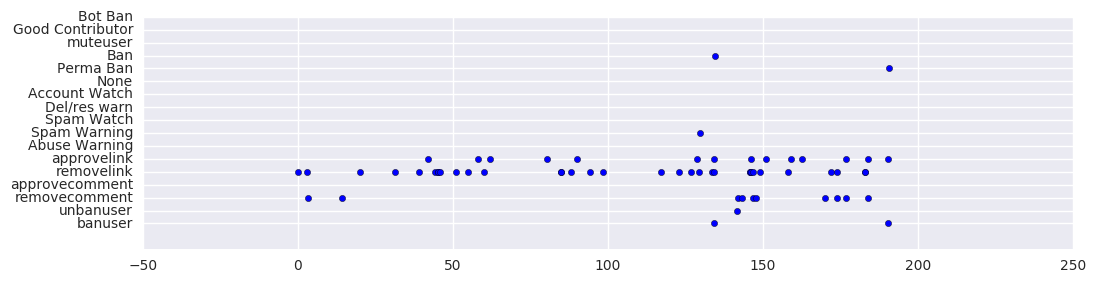

In [71]:
earliest_modaction = min([utc.localize(x['created_utc']) for x in actions])
for modlist in random.sample([x for x in [y[1] for y in user_moderation_experiences.items() if 
                                          y[0] in unbanned_users.keys()] 
                if(x['metadata']['notable_actions']>1 and 
                  x['metadata']['earliest_experience'] > earliest_modaction)], 5): 
    experiences = modlist['experiences']
    min_date = min([x['timestamp'] for x in experiences])

    days = []
    indices = []
    for experience in experiences:
        diff = experience['timestamp'] - min_date
        days_since = diff.days + diff.seconds / (60*60*24)
        days.append(days_since)
        type_index = all_types.index(experience['type'])
        indices.append(type_index)
    plt.figure(figsize=(12,3))
    plt.scatter(days, indices)
    plt.yticks(list(range(0,len(all_types))), all_types)
    plt.show()

### Create a Comments Dataset for Users That Were Banned

In [72]:
user_ids = ",".join(list(["'"+str(x)+"'" for x in banned_users.keys()]))
#user_ids

In [73]:
all_comments = []
count = 0

domains = set()

querytext = """
SELECT * FROM comments 
    WHERE subreddit_id='2rfxx' AND
    user_id IN ({0});
""".format(user_ids)

for row in db_engine.execute(text(querytext)):
# for row in db_engine.execute(text("select * from comments WHERE post_id IN (select posts.id from experiment_things JOIN posts on experiment_things.id = posts.id WHERE experiment_id=8 AND object_type=1);")):
    comment = {}
    for key in row.keys():
        comment[key] = row[key]
    comment_data = json.loads(comment['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    del comment['comment_data']
    
    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(comment['created_utc']))
    comment['body.length'] = len(comment['body'])
    comment['link_count'] = 0  #comment['body'].count("http")
        
#    comment['body'] = None
    comment['body_html'] = None
    comment['visible'] = True
    if(comment['body'] == "[removed]"):
        comment['visible'] = False
    
    all_comments.append(comment)
    count += 1
    if(count % 5000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()

#############################################
#### NOW ADD MODERATION ACTIONS TO COMMENTS
#############################################
comments_with_mod_actions = set()
mod_comment_actions = defaultdict(list)
for action in actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

removed_count = 0
approved_count = 0
for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
    if('body' in comment.keys()):
        del comment['body']
    
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

............211907 Total moderation actions
161894 Comments with moderation actions
45641 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 58151, False: 3547})
Took 5255 actions to set a comment to removed
Took 2314 actions to set a comment to approved


### Now Create an After Banned Dataset of Comment Experiences

In [74]:
banned_experiences = copy.copy(banned_users)
for comment in all_comments:
    comment_data = {"data":comment,
                    "source":"comments",
                    "submitter":None,
                    "timestamp":comment['created'],
                    "type":"comment"}
    author = comment['author'].lower()
    if(author in banned_experiences.keys()):
        banned_experiences[author]['experiences'].append(comment_data)
    else:
        sys.sydout.write("x")
        sys.stdout.flush()

### Now Create a Posts Dataset of Those Who Were Unbanned

In [75]:
all_submissions = []
count = 0

domains = set()

querytext = """
SELECT * FROM posts 
    WHERE subreddit_id='2rfxx';
"""

for row in db_engine.execute(text(querytext)):
    submission = {}
    for key in row.keys():
        submission[key] = row[key]
    submission_data = json.loads(submission['post_data'])
    for key in submission_data.keys():
        submission[key] = submission_data[key]
    del submission['post_data']
    
    if(submission['author'] not in user_ids):
        continue
    
    submission['created'] = utc.localize(datetime.datetime.utcfromtimestamp(submission['created_utc']))
    submission['body.length'] = len(submission['selftext'])

    submission['selftext_html'] = None
    submission['visible'] = True
    if(submission['selftext'] == "[removed]"):
        submission['visible'] = False
    
    all_submissions.append(submission)
    count += 1
    if(count % 5000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()

#############################################
#### NOW ADD MODERATION ACTIONS TO SUBMISSIONS
#############################################
submissions_with_mod_actions = set()
mod_submission_actions = defaultdict(list)
for action in actions:
     if action['action'] == "removelink" or action['action'] == "approvelink":
            submission_id = action['target_fullname'].replace("t3_", "")
            mod_submission_actions[submission_id].append(action)
            submissions_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_submission_actions.values()])))
print("{0} Submissions with moderation actions".format(len(mod_submission_actions)))
print("{0} Submissions with more than one mod action".format(len([x for x in mod_submission_actions.values() if len(x)>1])))
print("")

removed_count = 0
approved_count = 0
for submission in all_submissions:
    if('later_deleted' not in submission.keys()):
        submission['later_deleted'] = False
        if(submission['author'] =="[deleted]"):
            submission['later_deleted'] = True
    if submission['id'] in mod_submission_actions.keys():
        for action in mod_submission_actions[submission['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            submission['author']  = action['target_author']
            if action['action'] =="removelink":
                removed_count += 1
                submission['visible'] = False
            elif action['action'] == "approvelink":
                approved_count += 1
                submission['visible']  = True
    if('selftext' in submission.keys()):
        del submission['selftext']
        del submission['selftext_html']
    
print("Summary of Submission Visibility:")
print(Counter([x['visible'] for x in all_submissions]))
print("Took {0} actions to set a Submission to removed".format(removed_count))
print("Took {0} actions to set a Submission to approved".format(approved_count))

151480 Total moderation actions
122889 Submissions with moderation actions
17783 Submissions with more than one mod action

Summary of Submission Visibility:
Counter({True: 723, False: 172})
Took 185 actions to set a Submission to removed
Took 158 actions to set a Submission to approved


### Add Posts (Submissions) To Experience List for Banned Users

In [76]:
banned_experiences = copy.copy(banned_users)
for submission in all_submissions:
    submission_data = {"data":submission,
                    "source":"submissions",
                    "submitter":None,
                    "timestamp":submission['created'],
                    "type":"submission"}
    author = submission['author'].lower()
    if(author in banned_experiences.keys()):
        banned_experiences[author]['experiences'].append(submission_data)
    else:
        sys.stdout.write("x")
        sys.stdout.flush()

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### Now Sort All Experiences

In [77]:
observe_experience_types=set()
for account in banned_experiences.values():
    account['experiences'] = sorted(account['experiences'], key=lambda x: x['timestamp'])
    for experience in account['experiences']:
        observe_experience_types.add(experience['type'])

In [78]:
#observe_experience_types

### Now Create the Post-Unban Dataframe

In [87]:
# longitudinal dataframe
# - timestamp
# - type
# - removed by moderators
all_actions_after_unban = []

# per-person dataset
# only covers the following 3-week period
post_ban_period = cutoff_period_days
# - number of comments
# - number of removed comments
# - number of submissions
# - number of removed submissions
# - are they re-banned?
person_actions_after_unban = [] 
for username, account in banned_experiences.items():
    unbanned_timestamp = None
    banned_timestamp = None
    banned = False
    unbanned = False
    rebanned = False
    rebanned_within_period = False
    num_comments = 0
    num_comments_removed = 0
    num_submissions = 0
    num_submissions_removed = 0
    ever_received_ban_snoonote = False
    ever_received_warn_snoonote = False
    
    
    for experience in account['experiences']:
        experience = copy.copy(experience)
        experience['author']=username
        ### IF THE ACCOUNT IS REBANNED, STOP
        if(unbanned_timestamp is not None):
            time_since_unbanned = experience['timestamp'] - unbanned_timestamp
            days_since_unbanned = time_since_unbanned.days + 60*60*24 / time_since_unbanned.seconds
            experience['days_since_unbanned'] = days_since_unbanned 
            
            
        if(unbanned and experience['type'] in ["banuser", 'permaban']):
            rebanned = True
            if(days_since_unbanned <= post_ban_period):
                rebanned_within_period = True

            break
            
        if(banned_timestamp is None and unbanned_timestamp is None):
            if(experience['type'] =="banuser"):
                banned_timestamp = experience['timestamp']
                banned = True
         
        if(unbanned != True or days_since_unbanned <= post_ban_period):
            if(experience['type'] == 'Ban'):
                ever_received_ban_snoonote = True
        
        if(unbanned_timestamp is None and experience['type']=="unbanuser"):
            unbanned_timestamp = experience['timestamp']
            unbanned = True
            
        if(unbanned and experience['type'] in ['comment', 'submission']):
            #if it's within the specified period
            experience['visible'] = experience['data']['visible']
            if(days_since_unbanned <= post_ban_period):
                if(experience['type'] =="comment"):
                    num_comments += 1
                    if(experience['data']['visible'] == False):
                        num_comments_removed += 1
                elif(experience['type']=="submission"):
                    num_submissions += 1
                    if(experience['data']['visible'] == False):
                        num_submissions_removed += 1
            del experience['data']
            all_actions_after_unban.append(experience)
            
        if(unbanned!=True and experience['type'] in ['Spam Warning', 'Abuse Warning']):
            ever_received_warn_snoonote = True

    person_actions_after_unban.append({"account":username,
                                       "banned_timestamp":banned_timestamp,
                                       "unbanned_timestamp":unbanned_timestamp,
                                       "num_comments":num_comments,
                                       "num_comments_removed":num_comments_removed,
                                       "num_submissions":num_submissions,
                                       "num_submissions_removed":num_submissions_removed,
                                       "banned": banned,
                                       "unbanned": unbanned,
                                       "rebanned":rebanned,
                                       "rebanned_within_period":rebanned_within_period,
                                       "ever_received_ban_snoonote":ever_received_ban_snoonote,
                                       "ever_received_warn_snoonote":ever_received_warn_snoonote
    })
            
        

In [88]:
person_actions_after_unban[0]

{'account': 'imzarth',
 'banned': True,
 'banned_timestamp': datetime.datetime(2017, 1, 5, 12, 52, 24, tzinfo=<UTC>),
 'ever_received_ban_snoonote': False,
 'ever_received_warn_snoonote': True,
 'num_comments': 18,
 'num_comments_removed': 2,
 'num_submissions': 0,
 'num_submissions_removed': 0,
 'rebanned': False,
 'rebanned_within_period': False,
 'unbanned': True,
 'unbanned_timestamp': datetime.datetime(2017, 1, 5, 13, 52, 45, tzinfo=<UTC>)}

### Add Account Info to Person Dataset

In [100]:
banned_timestamps = {}

for person in person_actions_after_unban:
    
    if(person['account'] not in account_info.keys()):
        account_name = person['account']
        a = r.get_redditor(account_name)
        try:
            a.refresh()
        except: 
            pass
        account_info[account_name] = a.json_dict

    account = account_info[person['account']]
    banned_timestamps[person['account']] = person['banned_timestamp']
    
    if(account is not None and 'has_verified_email' in account.keys()):
        person['has_verified_email'] = account['has_verified_email']
    else:
        person['has_verified_email'] = None

    if(account is not None and 'created_utc' in account.keys()):
        person['account_created'] = utc.localize(datetime.datetime.utcfromtimestamp(account['created_utc']))
    else:
        person['account_created'] = None
    
    person['is_suspended_03.31.2017'] = False
    if(account is not None and 'is_suspended' in account.keys()):
        person['is_suspended_03.31.2017'] = account['is_suspended']

### Add Acount Info to Actions Dataset

In [101]:
for action in all_actions_after_unban:
    account = account_info[action['author'].lower()]
    action['banned_timestamp'] = banned_timestamps[action['author'].lower()]
    
    if(account is not None and 'has_verified_email' in account.keys()):
        action['has_verified_email'] = account['has_verified_email']
    else:
        action['has_verified_email'] = None

    if(account is not None and 'created_utc' in account.keys()):
        action['account_created'] = utc.localize(datetime.datetime.utcfromtimestamp(account['created_utc']))
    else:
        action['account_created'] = None
    
    action['is_suspended_03.31.2017'] = False
    if(account is not None and 'is_suspended' in account.keys()):
        action['is_suspended_03.31.2017'] = account['is_suspended']

### Write Data to Files

In [102]:
unbanned_people_df = pd.DataFrame(person_actions_after_unban)
unbanned_people_df.to_csv("outputs/r_leagueoflegends_banned_people_actions.03.31.2017.csv")

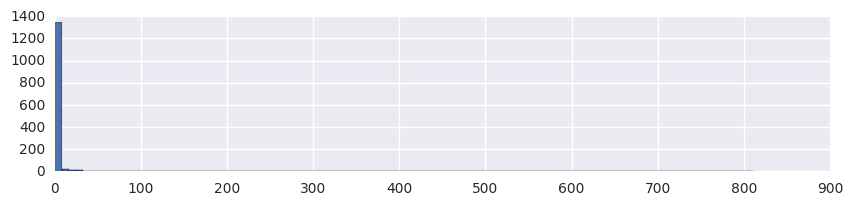

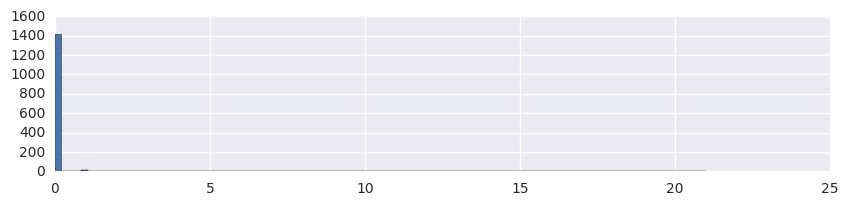

In [103]:
plt.figure(figsize=(10,2))
unbanned_people_df.num_comments.hist(bins=100)
plt.show()
plt.figure(figsize=(10,2))
unbanned_people_df.num_submissions.hist(bins=100)
plt.show()

In [104]:
#print("Reban Rate")
#print(unbanned_people_df.rebanned.describe())
#print("")
#print("Rebanned Within a Week")
#print(unbanned_people_df.rebanned_within_week.describe())

In [105]:
## TODO: BEFORE ADDING ACTIONS AFTER UNBAN, ADD A FIELD 
## TO INDICATE THE USER IN QUESTION
actions_df = pd.DataFrame(all_actions_after_unban)
actions_df.to_csv("outputs/r_leagueoflegends_unbanned_actions.03.31.2017.csv")

In [ ]:
actions_df.head(5)

In [ ]:
unbanned_people_df.head()

## Analysis of Ban/Note Consistency

In [841]:
import hashlib
def ban_note_actions():
    return {
        "mod_name":None,
        "banuser":0,
        "unbanuser":0,
        "removecomment":0,
        "approvecomment":0,
        "removelink":0,
        "approvelink":0,
        'Ban':0, 'Permaban':0,
        'Del/res warn':0, 'Bot Ban':0
    }
mod_ban_note_actions = defaultdict(ban_note_actions)
#earliest_mod_action = utc.localize(min([x['created_utc'] for x in actions]))
earliest_mod_action = utc.localize(parser.parse("nov 8 2016"))

In [842]:
for action in actions:
    if action['action'] in ['banuser','unbanuser']:
        ## TEMPORARY LINE OF CODE
        if(utc.localize(action['created_utc']) > earliest_mod_action):
            modhash =  hashlib.sha224(action['mod'].encode('utf-8')).hexdigest()
            mod_ban_note_actions[modhash][action['action']]+=1
            mod_ban_note_actions[modhash]['mod_name'] = action['mod'].encode('utf8')

In [843]:
for user in sub_user_notes.values():
    for note in user:
        if(parser.parse(note['Timestamp']) >( earliest_mod_action  - datetime.timedelta(seconds=60*60))):
            if(note['NoteTypeName'] in ['Ban', 'Permaban','Del/res warn', 'Bot Ban']):
                modhash =  hashlib.sha224(note['Submitter'].encode('utf-8')).hexdigest()
                mod_ban_note_actions[modhash][note['NoteTypeName']]+=1
                mod_ban_note_actions[modhash]['mod_name'] = note['Submitter'].encode('utf8')


In [844]:
#list(mod_ban_note_actions.values())[5]


In [845]:
for mod in mod_ban_note_actions.values():
    mod['Ban + Bot Ban + Perma Ban']  = mod['Ban'] + mod['Bot Ban']
    mod['banuser - Snoonote Ban'] = mod['banuser'] - mod['Ban + Bot Ban + Perma Ban'] 
    mod['banuser - Ban'] = mod['banuser'] - mod['Ban'] 
    
print("Max Snoonote Ban: {0}".format(max([x['Ban + Bot Ban + Perma Ban'] for x in mod_ban_note_actions.values()])))
print("Max banuser: {0}".format(max([x['banuser'] for x in mod_ban_note_actions.values()])))

Max Snoonote Ban: 166
Max banuser: 232


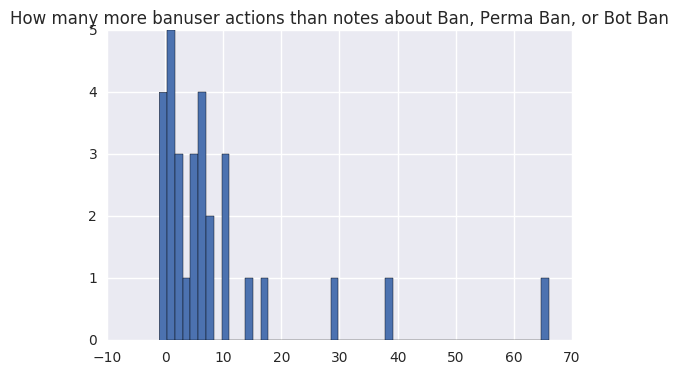

In [846]:
plt.hist([x['banuser - Snoonote Ban'] for x in mod_ban_note_actions.values()], bins=50)
plt.title("How many more banuser actions than notes about Ban, Perma Ban, or Bot Ban")
plt.show()

#plt.hist([x['banuser - Ban'] for x in mod_ban_note_actions.values()])
#plt.title("")
#plt.show()
#plt.scatter([x['Ban + Bot Ban'] for x in mod_ban_note_actions.values()])

In [852]:
np.median([x['banuser - Snoonote Ban'] for x in mod_ban_note_actions.values() if x['banuser - Snoonote Ban']>0])

5.0

In [848]:
len(mod_ban_note_actions)

30

### Random sample of accounts that were banned without any Ban Note

In [864]:
banned_user_usernames = []
banned_user_no_note = []
banned_user_has_note = []

for username, data in banned_users.items():
    #banned_user_usernames.append(username)
    if(username.lower() not in sub_user_notes.keys()):
        banned_user_no_note.append(username)
    else:
        banned_user_has_note.append(username)
print("A proportion of {0} banned users have no note".format(len(banned_user_no_note) / len(banned_users)))

print("")
print("HAS NO NOTE:")
print("")
for name in random.sample(banned_user_no_note, 10):
    print(name)

# print("")
# print("HAS A NOTE:")
# print("")
# for name in random.sample(banned_user_has_note, 20):
#     print(name)
    

A proportion of 0.2961240310077519 banned users have no note

HAS NO NOTE:

qasdfer
Satalizer
MohammedLobster
riotkysplz
Woessoe
bernatilis
TransphobicMods
EUFANSIN2016LUL
PM-FNATIC-FAN-TEARS
SUCK_IT_NOW_NA


In [851]:
lc_usernames_with_notes = [x.lower() for x in usernames_with_notes]
Counter([x in lc_usernames_with_notes for x in banned_user_no_note])

Counter({False: 382})

In [780]:
print(len(sub_user_notes))
print(len(usernames_with_notes))

11592
11593


In [861]:
for x in mod_ban_note_actions.values():
    x['proportional_discrepancy'] = (x['banuser - Snoonote Ban']+1) / (x['banuser'] +1)

In [865]:
#sorted([x for x in mod_ban_note_actions.values() if x['banuser - Snoonote Ban']>0], 
#       key=lambda x: x['banuser - Snoonote Ban'], reverse=True)

In [884]:
actions[0]

{'action': 'removecomment',
 'created_at': datetime.datetime(2016, 12, 3, 3, 53, 47),
 'created_utc': datetime.datetime(2016, 9, 3, 23, 58, 41),
 'description': None,
 'details': 'Blacklisted word, retard',
 'id': 'ModAction_dddfd834-7253-11e6-80b6-0e18eb2eb5c7',
 'mod': 'AutoModerator',
 'mod_id36': '6l4z3',
 'sr_id36': '2rfxx',
 'subreddit': 'leagueoflegends',
 'subreddit_id': '2rfxx',
 'target_author': 'Dr_Foppo',
 'target_body': "which was a surprisingly retarded thing for him to say\n\ni mean...i'm no sports psychologist but still a psychologist myself and I can't imagine a fellow psychologist believing so strongly that genetics and inherent attributes aren't important, like: intelligence; body figure - including hight, number of muscle cells, size of fat cells; eye-hand coordination and general coordination; etc.\n\n",
 'target_fullname': 't1_d78ryuv',
 'target_permalink': '/r/leagueoflegends/comments/5113lr/konstantinos_forg1ven_tzortziou_2016_ama/d78ryuv/',
 'target_title': Non

In [894]:
#[x for x in actions if action['target_author'] in banned_user_no_note[40]]
reasons = defaultdict(int)
details = [x['details'].split() for x in actions if x['details'] is not None and x['action']=='banuser']
for detail in details:
    for reason in detail:
        reasons[reason] +=1

In [895]:
reasons

defaultdict(int, {'1': 4, '7': 11, 'days': 15, 'permanent': 1551})

## Question: What Percentage of Banned Users Get Unbanned?

In [991]:
def was_unbanned_dict():
    return {"username":None,
            "banned": None, #timestamp
            "unbanned": None, #timestamp
            "rebanned": None,
            "warned": None} #timestamp

users_were_unbanned = defaultdict(was_unbanned_dict)

counter = 0
unbancount = 0

for username, user_object in user_moderation_experiences.items():
    user_was_unbanned = was_unbanned_dict()
    something_recorded = False
    
    for experience in user_object['experiences']:
        
        if(experience['type']=='Abuse Warning' or 
           experience['type']=='Spam Warning'):
            received_warning= True
            user_was_unbanned['warned'] = experience['timestamp']
            something_recorded = True
            
        
        ## BREAK IF WE ONLY OBSERVE PART OF THE
        ## BAN JOURNEY OF THIS PARTICULAR ACCOUNT
#         if((experience['type'] =="Perma Ban" or
#             experience['type'] == 'Bot Ban') and
#             user_was_unbanned['rebanned'] is None):
#             break
            
        if(experience['type']=='banuser'):
            if(user_was_unbanned['banned'] is None and 
               experience['timestamp'] <= utc.localize(period_before_final_date)):
                user_was_unbanned['banned'] = experience['timestamp']
                something_recorded = True
            elif(user_was_unbanned['unbanned'] is not None):
                user_was_unbanned['rebanned'] = experience['timestamp']
                something_recorded = True
                break

        elif(experience['type']=='unbanuser' and user_was_unbanned['unbanned'] is None and
             user_was_unbanned['banned'] is not None):
            unbancount += 1
            if(unbancount % 10 ==0):
                sys.stdout.write("u")
                sys.stdout.flush()
            user_was_unbanned['unbanned'] = experience['timestamp']
            something_recorded = True

    if(something_recorded):
        users_were_unbanned[username] = user_was_unbanned

    counter += 1
    if(counter % 1000 ==0):
        sys.stdout.write(".")
        sys.stdout.flush()

....u..u....u.....u....u.......u....u..u....u...u....u.....u..u...u....u...u....u...u....u.....u....u.....u.....u..u

In [1002]:
actions_after_unban = {}
for person in person_actions_after_unban:
    actions_after_unban[person['account'].lower()]  = person

boolean_keys = ['rebanned_within_period', 'rebanned', 'ever_received_ban_snoonote']
numeric_keys = ['num_submissions', 'num_comments_removed', 'num_comments', 'num_submissions_removed']
for username,user in users_were_unbanned.items():
    if username in actions_after_unban.keys():
        person = actions_after_unban[username]
        for key in boolean_keys:
            user[key] = person[key]
        for key in numeric_keys:
            user[key] = person[key]
    else:
        for key in boolean_keys:
            user[key] = False
        for key in numeric_keys:
            user[key] = 0        

In [1003]:
#len(user_moderation_experiences)
#list(user_moderation_experiences.values())[0]['experiences'][0]
#list(users_were_unbanned.values())[10]
#user_was_unbanned
#experience
#Counter([x['banned']!=None for x in users_were_unbanned.values()])
unbanned_users_df = pd.DataFrame(list(users_were_unbanned.values()))
unbanned_users_df.to_csv("outputs/r_leagueoflegends_banned_people_actions.03.07.2017.csv")

In [997]:
unbanned_users_df[(pd.isnull(unbanned_users_df.banned)!=True) & 
                   (pd.isnull(unbanned_users_df.warned)!=True)].count()

banned      608
rebanned      0
unbanned    148
username      0
warned      608
dtype: int64

In [1008]:
unbanned_users_df.count()

banned                        1290
ever_received_ban_snoonote    7336
num_comments                  7336
num_comments_removed          7336
num_submissions               7336
num_submissions_removed       7336
rebanned                      7336
rebanned_within_period        7336
unbanned                       241
username                         0
warned                        6654
dtype: int64

In [1001]:
person_actions_after_unban[0]

dict_keys(['num_submissions', 'account_created', 'rebanned_within_period', 'has_verified_email', 'rebanned', 'is_suspended', 'account', 'num_comments_removed', 'unbanned_timestamp', 'num_comments', 'ever_received_ban_snoonote', 'num_submissions_removed'])

In [1011]:
print("CAT")

CAT
